# Doc 3 - Análise das funções do github e da rede do paper

O que foi feito aqui:

1 - Análise do código do github do pré-processamento de dados: Novamente foram analisadas as imagens que são geradas a partir do código original do github e foram comparadas com as imagens que são produzidas a partir do uso da biblioteca pydicom, além de também analisar seus respectivos histogramas.

2 - Cógido da rede: Encontrei o github do código gerado para o treinamento da rede usado no paper.

## 1 - Análise do código do github

O próposito dessa parte é de ver o que a função do github faz de diferente da função já pronta do pydicom para abrir imagens dicom, pois na última reunião era possível ver a diferença na representação das imagens abertas com af funções. Especulou-se que eram diferentes apenas visualmente, por meio de uma possível alteração nos pixels da imagem.

In [1]:
#Imports 
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import tensorflow_io as tfio
import tensorflow as tf
import cv2
from collections import Counter

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


A baixo o código integral do github.

In [2]:
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union

import matplotlib
import numpy as np
import pandas as pd
import pydicom as dicom
from skimage.exposure import rescale_intensity


def dcmread_image(
    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
    view: str,
    index: Optional[np.uint] = None,
) -> np.ndarray:
    """Read pixel array from DBT DICOM file"""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name="pylibjpeg")
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(
        pixel_array, in_range=(low, high), out_range="dtype"
    )
    return pixel_array


def read_boxes(
    boxes_fp: pd._typing.FilePathOrBuffer, filepaths_fp: pd._typing.FilePathOrBuffer
) -> pd.DataFrame:
    """Read pandas DataFrame with bounding boxes joined with file paths"""
    df_boxes = pd.read_csv(boxes_fp)
    df_filepaths = pd.read_csv(filepaths_fp)
    primary_key = ("PatientID", "StudyUID", "View")
    if not all([key in df_boxes.columns for key in primary_key]):
        raise AssertionError(
            f"Not all primary key columns {primary_key} are present in bounding boxes columns {df_boxes.columns}"
        )
    if not all([key in df_boxes.columns for key in primary_key]):
        raise AssertionError(
            f"Not all primary key columns {primary_key} are present in file paths columns {df_filepaths.columns}"
        )
    return pd.merge(df_boxes, df_filepaths, on=primary_key)


def draw_box(
    image: np.ndarray,
    x: int,
    y: int,
    width: int,
    height: int,
    color: Optional[Union[int, tuple]] = None,
    lw=4,
):
    """Draw bounding box on the image"""
    x = min(max(x, 0), image.shape[1] - 1)
    y = min(max(y, 0), image.shape[0] - 1)
    if color is None:
        color = np.max(image)
    if len(image.shape) > 2 and not hasattr(color, "__len__"):
        color = (color,) + (0,) * (image.shape[-1] - 1)
    image[y : y + lw, x : x + width] = color
    image[y + height - lw : y + height, x : x + width] = color
    image[y : y + height, x : x + lw] = color
    image[y : y + height, x + width - lw : x + width] = color
    return image


def evaluate(
    labels_fp: pd._typing.FilePathOrBuffer,
    boxes_fp: pd._typing.FilePathOrBuffer,
    predictions_fp: pd._typing.FilePathOrBuffer,
) -> Dict[str, float]:
    """Evaluate predictions"""
    df_labels = pd.read_csv(labels_fp)
    df_boxes = pd.read_csv(boxes_fp, dtype={"VolumeSlices": float})
    df_pred = pd.read_csv(predictions_fp, dtype={"Score": float})

    df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_boxes = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_pred = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

    df_pred["TP"] = 0
    df_pred["GTID"] = -1

    thresholds = [df_pred["Score"].max() + 1.0]

    # find true positive predictions and assign detected ground truth box ID
    for box_pred in df_pred.itertuples():
        if box_pred.Index not in df_boxes.index:
            continue

        df_boxes_view = df_boxes.loc[[box_pred.Index]]
        view_slice_offset = df_boxes.loc[[box_pred.Index], "VolumeSlices"].iloc[0] / 4
        tp_boxes = [
            b
            for b in df_boxes_view.itertuples()
            if _is_tp(box_pred, b, slice_offset=view_slice_offset)
        ]
        if len(tp_boxes) > 1:
            # find the nearest GT box
            tp_distances = [_distance(box_pred, b) for b in tp_boxes]
            tp_boxes = [tp_boxes[np.argmin(tp_distances)]]
        if len(tp_boxes) > 0:
            tp_i = tp_boxes[0].index
            df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
            thresholds.append(box_pred.Score)

    thresholds.append(df_pred["Score"].min() - 1.0)

    # compute sensitivity at 2 FPs/volume on all cases
    evaluation_fps_all = (2.0,)
    tpr_all = _froc(
        df_pred=df_pred,
        thresholds=thresholds,
        n_volumes=len(df_labels),
        n_boxes=len(df_boxes),
        evaluation_fps=evaluation_fps_all,
    )
    result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

    # compute mean sensitivity at 1, 2, 3, 4 FPs/volume on positive cases
    df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
    df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
    evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
    tpr_positive = _froc(
        df_pred=df_pred,
        thresholds=thresholds,
        n_volumes=len(df_labels),
        n_boxes=len(df_boxes),
        evaluation_fps=evaluation_fps_positive,
    )

    result.update(
        dict(
            (f"sensitivity_at_{int(x)}_fps_positive", y)
            for x, y in zip(evaluation_fps_positive, tpr_positive)
        )
    )
    result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

    return result


def _froc(
    df_pred: pd.DataFrame,
    thresholds: List[float],
    n_volumes: int,
    n_boxes: int,
    evaluation_fps: tuple,
) -> List[float]:
    tpr = []
    fps = []
    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(
            subset=["StudyUID", "View", "TP", "GTID"]
        )
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)
        if fps_th > max(evaluation_fps):
            break
    return [np.interp(x, fps, tpr) for x in evaluation_fps]


def _is_tp(
    box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100
) -> bool:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    # 2D distance between true and predicted center points
    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    # compute radius based on true box size
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff = np.abs(pred_z - true_z)
    # TP if predicted center within radius and slice within slice offset
    return dist <= dist_threshold and slice_diff <= slice_offset


def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))


def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Unreliable - DICOM laterality is incorrect for some cases"""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value


def _get_image_laterality(pixel_array: np.ndarray) -> str:
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"


def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)


def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

Aqui é a função do github modificada, comentando as linhas que parecem ter o propósito de apenas mudar os valores dos pixels da imagem.

In [3]:
def dcmread_image2(
    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
    view: str,
    index: Optional[np.uint] = None,
) -> np.ndarray:
    """Read pixel array from DBT DICOM file"""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name="pylibjpeg")
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    #pixel_array = rescale_intensity(
    #    pixel_array, in_range=(low, high), out_range="dtype"
    #)
    return pixel_array

In [4]:
%%time
df = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\Imagens\BCS-DBT-file-paths-test-v2.csv") #Arquivo das paths para pegar as imagens
view_series = df.iloc[668]
view = view_series["View"]
image_path = os.path.join(r'D:/Coisinhas/Coisas_UNB/TCC/Imagens/manifest-1708019969874/', view_series["descriptive_path"])
imageCode = dcmread_image(fp=image_path, view=view)

C:\Users\breno\anaconda3\lib\site-packages\openjpeg\utils.py:313: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


CPU times: total: 14 s
Wall time: 55.7 s


Aqui mostra a imagem usando o código integral.

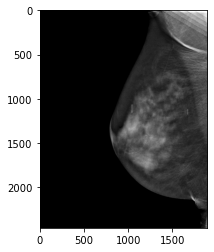

In [5]:
plt.imshow(imageCode[0], cmap=plt.cm.gray)

In [6]:
imageCode[0]

array([[    0,     0,     0, ..., 65535, 65535, 65535],
       [    0,     0,     0, ..., 65535, 65535, 65535],
       [    0,     0,     0, ..., 65535, 65535, 65535],
       ...,
       [    0,     0,     0, ..., 41599, 38911, 36991],
       [    0,     0,     0, ..., 39039, 39167, 38655],
       [    0,     0,     0, ..., 38015, 37247, 36351]], dtype=uint16)

In [7]:
%%time
df = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\Imagens\BCS-DBT-file-paths-test-v2.csv") #Arquivo das paths para pegar as imagens
view_series = df.iloc[668]
view = view_series["View"]
image_path = os.path.join(r'D:/Coisinhas/Coisas_UNB/TCC/Imagens/manifest-1708019969874/', view_series["descriptive_path"])
imageCodeMod = dcmread_image2(fp=image_path, view=view)

CPU times: total: 9.14 s
Wall time: 17.9 s


E aqui tem-se a imagem com o código modificado.

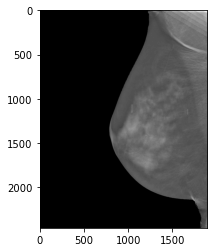

In [8]:
plt.imshow(imageCodeMod[0], cmap=plt.cm.gray)

Agora a imagem usando a própria função do pydicom.

C:\Users\breno\anaconda3\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


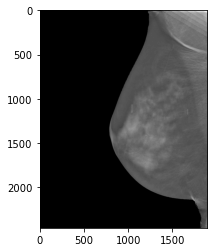

In [9]:
image_path = r'D:\Coisinhas\Coisas_UNB\TCC\Imagens\manifest-1708019969874\Breast-Cancer-Screening-DBT\DBT-P00004\01-01-2000-DBT-S03764-MAMMO screening digital bilateral-73497\11920.000000-70893\1-1.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array[0], cmap = 'gray')

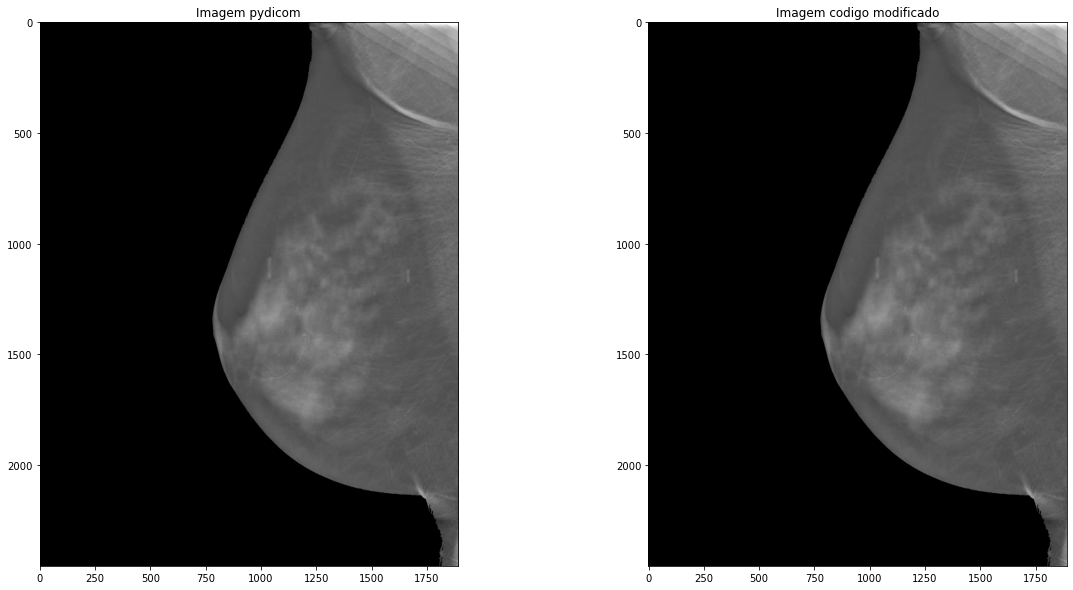

In [10]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(ds.pixel_array[0], cmap='gray')
plt.title('Imagem pydicom')

plt.subplot(1, 2, 2)
plt.imshow(imageCodeMod[0], cmap='gray')
plt.title('Imagem codigo modificado')


plt.show()

<b>Para o olho humano</b>, a imagem pydicom e a do código modificado parecem ser extremamente próximas. Contudo, convém analisar se os valores de seus pixels realmente são iguais.

In [11]:
ds.pixel_array[0]

array([[   0,    0,    0, ..., 1022, 1022, 1022],
       [   0,    0,    0, ..., 1022, 1022, 1022],
       [   0,    0,    0, ..., 1022, 1022, 1022],
       ...,
       [   0,    0,    0, ...,  581,  560,  545],
       [   0,    0,    0, ...,  561,  562,  558],
       [   0,    0,    0, ...,  553,  547,  540]], dtype=uint16)

In [12]:
imageCodeMod[0]

array([[   0,    0,    0, ..., 1022, 1022, 1022],
       [   0,    0,    0, ..., 1022, 1022, 1022],
       [   0,    0,    0, ..., 1022, 1022, 1022],
       ...,
       [   0,    0,    0, ...,  581,  560,  545],
       [   0,    0,    0, ...,  561,  562,  558],
       [   0,    0,    0, ...,  553,  547,  540]], dtype=uint16)

Podemos ver que pelo menos parcialmente são iguais.

In [13]:
ds.pixel_array[0].shape

(2457, 1890)

In [14]:
imageCodeMod[0].shape

(2457, 1890)

As dimensões também são iguais, então podemos checar a igualdade direta entre os arrays.

In [15]:
ds.pixel_array[0] == imageCodeMod[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [16]:
np.array_equal(ds.pixel_array[0], imageCodeMod[0])

True

Podemos conlcuir que todos os valores são realmente iguais. O que o código do github faz realmente é so uma alteração nos valores dos pixels, uma possível equalização no histrograma.

Adicionalmente, vamos também dar uma olhada nos histogramas das imagens e ver o que acontece quando equaliamos ele.

Primeiro escolhi normalizar os valores da imagem de 0 até 255, pois quando olhamos os valores do arrays eles são bem altos.

In [17]:
#Normalizacao da imagem pydicom
imageTest = ds.pixel_array[0]
imageTest = imageTest/imageTest.max()
imageTest = imageTest*255
imageTest

array([[  0.        ,   0.        ,   0.        , ..., 254.75073314,
        254.75073314, 254.75073314],
       [  0.        ,   0.        ,   0.        , ..., 254.75073314,
        254.75073314, 254.75073314],
       [  0.        ,   0.        ,   0.        , ..., 254.75073314,
        254.75073314, 254.75073314],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 144.82404692,
        139.58944282, 135.85043988],
       [  0.        ,   0.        ,   0.        , ..., 139.83870968,
        140.08797654, 139.09090909],
       [  0.        ,   0.        ,   0.        , ..., 137.84457478,
        136.34897361, 134.60410557]])

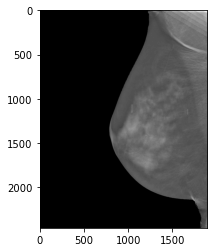

In [18]:
plt.imshow(imageTest, cmap = 'gray')

Visualmente podemos ver que a imagem não mudou. Vamos agora ver seu histograma:

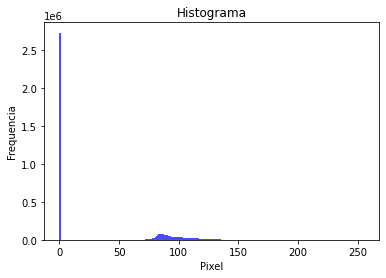

In [19]:
#Flatten da imagem para pegar todos os valores dos pixels
flat_array1 = imageTest.flatten()


plt.hist(flat_array1, bins=256, range=(0, 255), density=False, color='b', alpha=0.7)
plt.xlabel('Pixel')
plt.ylabel('Frequencia')
plt.title('Histograma')
plt.show()

Como esperado, a maioria dos pixels são pretos por conta do background. Vamos ver o que acontece se equalizarmos o histograma:

In [20]:
def histogram_equalization(pixel_array):
    #Pega o histograma
    hist, bins = np.histogram(pixel_array, bins=256, range=(0, 255), density=True)

    #Calcula a CDF
    cdf = hist.cumsum()
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    
    #Faz a equalizacao
    equalized_pixel_array = np.interp(pixel_array, bins[:-1], cdf_normalized)

    return equalized_pixel_array.astype(np.uint8)

In [21]:
equalized_image = histogram_equalization(imageTest)

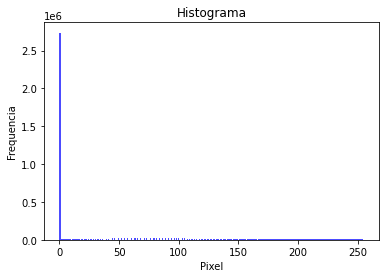

In [22]:
flat_array_eq = equalized_image.flatten()


plt.hist(flat_array_eq, bins=256, range=(0, 255), density=False, color='b', alpha=0.7)
plt.xlabel('Pixel')
plt.ylabel('Frequencia')
plt.title('Histograma')
plt.show()

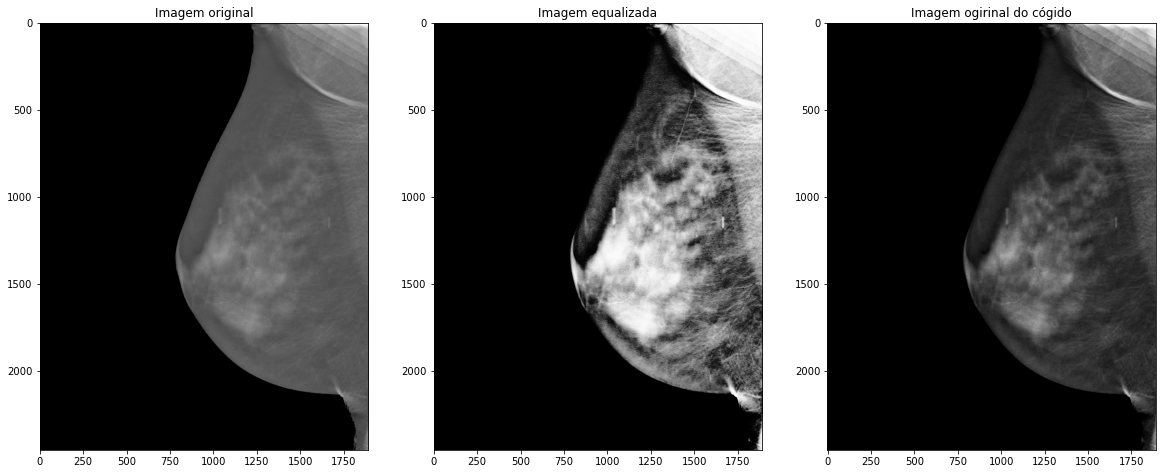

In [23]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(imageTest, cmap='gray')
plt.title('Imagem original')

plt.subplot(1, 3, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title('Imagem equalizada')

plt.subplot(1, 3, 3)
plt.imshow(imageCode[0], cmap='gray')
plt.title('Imagem ogirinal do cógido')

plt.show()

Podemos ver que o código do github faz não é uma simples equalização. Convém analisar também seu histograma.

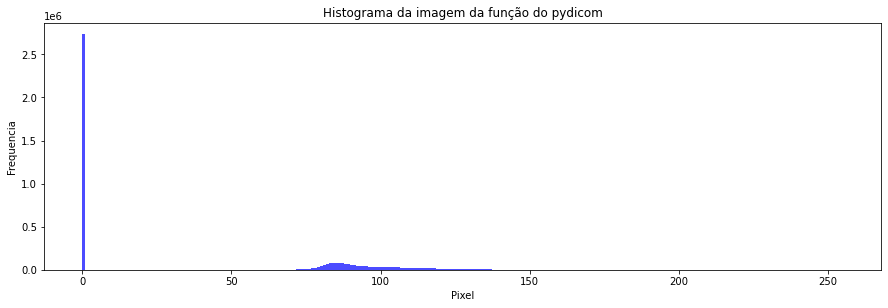

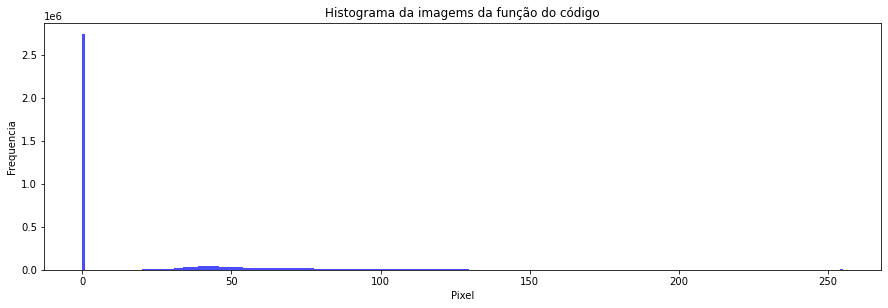

In [24]:
imageTest = imageCode[0]
imageTest = imageTest/imageTest.max()
imageTest = imageTest*255

flat_array2 = imageTest.flatten() #Esse é o array da imagem do código original

#Histograma da imagem pydicom
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.hist(flat_array1, bins=256, range=(0, 255), density=False, color='b', alpha=0.7)
plt.xlabel('Pixel')
plt.ylabel('Frequencia')
plt.title('Histograma da imagem da função do pydicom')
plt.show()

#Histograma da imagem do codigo original
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 2)
plt.hist(flat_array2, bins=256, range=(0, 255), density=False, color='b', alpha=0.7)
plt.xlabel('Pixel')
plt.ylabel('Frequencia')
plt.title('Histograma da imagems da função do código')
plt.show()

In [25]:
np.array_equal(flat_array1, flat_array2)

False

Podemos ver que o que o código faz não é uma mera equalização, mas sim uma "alongamento" dos valores, além de trazê-los mais perto do preto

Uma outra coisa que gostaria de destacar é o fato que é sim possível abrir o arquivo dicom "cru" com python e ver as informações de seu header. Infelismente não parece conter o diagnóstico.

In [26]:
ds_info = dicom.read_file(image_path)
ds_info

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Breast Tomosynthesis Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.31475544807310294180293431952578350880
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'TOMOSYNTHESIS', 'NONE']
(0008, 0016) SOP Class UID                       UI: Breast Tomosynthesis Image Storage
(0008, 0018) SOP Instan

## 2 - Código da rede do paper

O paper é bem breve sobre como estrutura a rede neural:

<b>Preprocessing</b>

First, we applied a basic preprocessing by window leveling images based on information from the
Digital Imaging and Communications in Medicine file header. Then, each slice was downscaled by a
factor of 2 using 2 × 2 local mean filter to reduce computational and memory footprint. After that, we
eroded nonzero image pixels with a filter of 5-pixel radius for skin removal. Finally, we extracted the
largest connected component of nonzero pixels for segmenting the breast region.

<b>Detection Algorithm</b>

For a baseline method to detect lesions, we used a single-phase fully convolutional neural network
for 2-D object detection with DenseNet architecture. The model processes each 2-D input slice
independently. Following this, raw model predictions correspond to a grid in the input slice image
with cells sized 96 × 96 pixels. For each cell, the network outputs a confidence score for containing
the center point of a box and 4 values defining the location and dimensions of the predicted box. A
bounding box is defined by offset from the cell center point as well as scale in relation to a square
anchor box sized 256 × 256 pixels. Each cell was restricted to predicting exactly 1 bounding box.
The network was optimized using Adam, with an initial learning rate of 0.001 and batch size of
16 for 100 epochs over positive examples and early stopping strategy with a patience of 25 epochs.
Weights were randomly initialized using the Kaiming method, and biases in the last layer were set
according to Lin et al.
For training, we sampled positive slices containing ground truth boxes from volumes belonging
to the biopsied groups. The number of positive slices (ie, slices containing a tumor) was established
as the square root of the average dimension in pixels of the box drawn by a radiologist on the center
slice of the tumor. The ground truth 3-D box was defined by the 2-D rectangle drawn by the
radiologist with the third dimension defined by the number of slices, as described previously. Then,
we randomly cropped a slice image to a size of 1056 × 672 pixels, which resulted in an output grid
sized 11 × 7 pixels so that the cropped slice image included the entire ground truth bounding box. For
validation, the slice span of ground truth boxes was reduced by a factor of 2 compared with the
training phase, and we fixed selected slice and cropped slice image regions for each case. This was
done to ensure comparable validation performance was measured based on the same input slice for
all runs and across epochs. All hyperparameters and algorithmic strategies described previously were
decided on the validation set.
During inference, we used entire image slices as the input and padded them with zeros when
necessary to match the label grid size. To obtain predictions for a volume, we split it into halves and
combined slice-based predictions for each half by averaging them. Then, we applied the following
postprocessing. First, predicted boxes for which fewer than half the pixels were in the breast region
were discarded to eliminate false-positive predictions outside of the breast. Then, we applied a
nonmaximum suppression algorithm17 by merging all pairs of predicted boxes that had a confidence
score ratio of less than 10 and an intersection over union greater than 50%. The confidence score
of a resulting box was a maximum of scores from the 2 merged boxes.

<b>Consegui também encontrar o github do código com a rede, que por algum motivo não era mencionado nem na base de dados nem no site do paper e é um github separado daquele do processamento das imagens. </b> 

Infelizmente, o código foi criado em torch.

https://github.com/mateuszbuda/duke-dbt-detection

https://keras.io/api/applications/densenet/